Scanning: /workspace/obsidian
Processing 23405 notes...

--- Top Cluster Identifiers ---
C0: risk management, job search, operational risk, management risk, career development, management business, business development, search career, compliance risk, risk risk
C1: social media, media social, social marketing, social networking, media marketing, marketing social, shadow banning, media platforms, networking social, shadow banned
C2: critical thinking, martinsville va, va 24112, william hitt, justin william, 1100 cherokee, cherokee ct, cherokee court, court martinsville, liyu chen
C3: lead generation, copywriting tips, content marketing, adbriefing copywriting, adbriefing uk, marketing content, copy sells, justin hitt, tips item, write copy
C4: pm tags, justin hitt, cash flow, make sure, note taking, facebook reply, united states, direct response, high income, artificial intelligence
C5: date version, v0 justin, justin hitt, version contact, contact comment, 2018 v0, 2017 v0, 2019 v0, ti

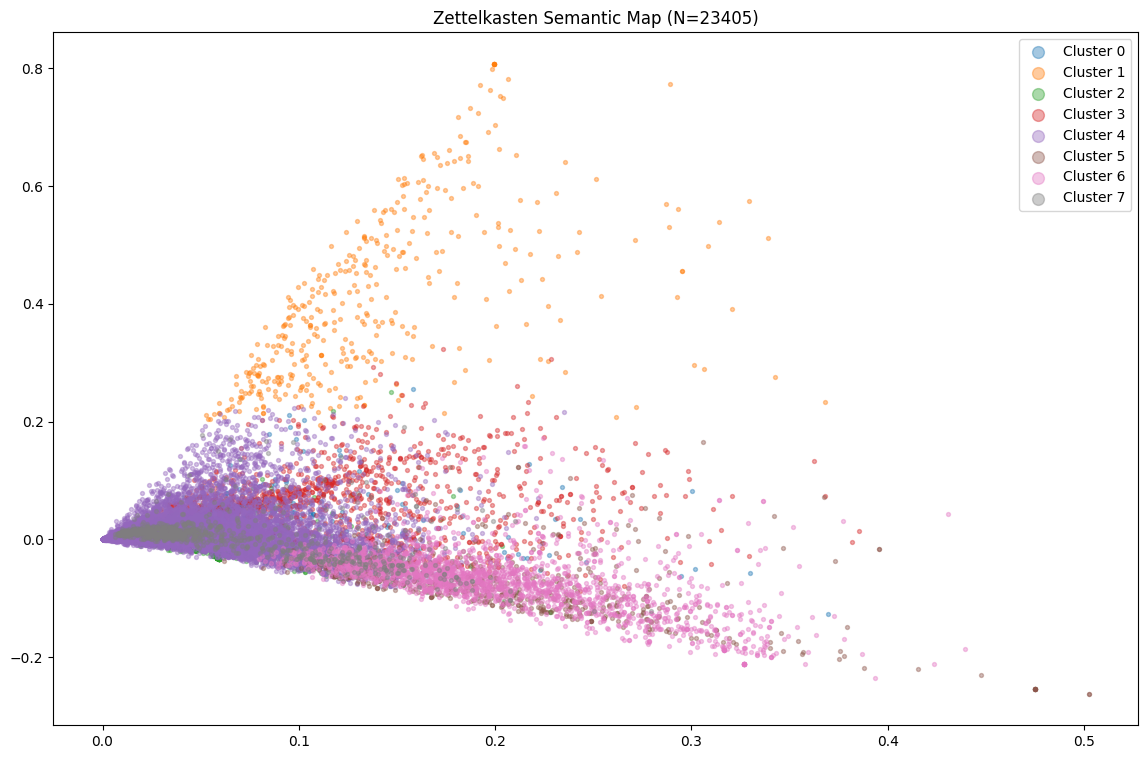

In [ ]:
import os
import re
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# --- Tuning & Hyperparameters ---
N_CLUSTERS = 8           
TAG_WEIGHT = 5           
MAX_FEATURES = 5000      
NGRAM_RANGE = (2, 2)     
MIN_DOC_FREQ = 5         

CUSTOM_STOP_WORDS = {
    'https', 'http', 'com', 'www', 'org', 'net', 'html', 'eof', 
    'g_face', 'q_auto', 'image', 'png', 'jpg', 'figure', 'ref', 'v0'
}

# --- Performance & Disk Filtering ---
ZETTEL_ROOT = "/workspace/obsidian" 
DIRECTORY_EXCLUSIONS = {"Templates", "node_modules", "Archive"} 
FILE_EXCLUSIONS = ["TEMPLATE"] 

# --- Processing Functions ---

def split_camel_case(text):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

def is_date_pattern(text):
    text_str = str(text).strip()
    # Matches YYYY-MM-DD, YYYYMMDD, and the 12-digit Zettel ID YYYYMMDDhhmm
    return bool(re.match(r'^\d{4}(-\d{2}(-\d{2})?)?$|^\d{8}$|^\d{12}$', text_str))

def clean_structure(text):
    """
    1. Removes WikiLinks [[Link]]
    2. Removes Zettelkasten IDs (12-digit timestamps)
    3. Filters headers by word count (> 2 words)
    4. Segments text to prevent n-gram bleeding
    """
    # Remove WikiLinks: [[Target|Alias]] -> Alias or Target
    # We keep the text inside the link but remove the brackets
    text = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # Remove standalone 12-digit Zettel IDs (YYYYMMDDhhmm)
    text = re.sub(r'\b\d{12}\b', '', text)
    
    lines = text.split('\n')
    valid_segments = []
    
    for line in lines:
        clean_line = line.strip()
        if not clean_line:
            continue
            
        if clean_line.startswith('#'):
            # Extract header content
            header_content = re.sub(r'^#+\s*', '', clean_line).strip()
            # ONLY keep headers with 3 or more words
            if len(header_content.split()) > 2:
                valid_segments.append(header_content)
        else:
            # It's body text: remove any stray 12-digit IDs within the line
            clean_body = re.sub(r'\b\d{12}\b', '', clean_line).strip()
            if clean_body:
                valid_segments.append(clean_body)
            
    # Join with a period to act as an n-gram boundary
    return ". ".join(valid_segments)

def extract_note_data(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
    except Exception:
        return None

    # 1. YAML Tags
    yaml_tags = []
    yaml_match = re.search(r'^---\s*\n(.*?)\n---\s*\n', content, re.DOTALL)
    if yaml_match:
        try:
            meta = yaml.safe_load(yaml_match.group(1))
            if meta and 'tags' in meta:
                raw_tags = meta['tags']
                if isinstance(raw_tags, list):
                    yaml_tags = [str(t) for t in raw_tags if t is not None and not is_date_pattern(t)]
                elif raw_tags is not None and not is_date_pattern(raw_tags):
                    yaml_tags = [str(raw_tags)]
        except: pass

    # 2. Hashtags
    hashtag_raw = re.findall(r'#([A-Z][a-z]+(?:[A-Z][a-z]+)+)', content)
    hashtag_split = [split_camel_case(ht) for ht in hashtag_raw if not is_date_pattern(ht)]
    
    # 3. Body/Header Refinement
    # Strip YAML block first
    body_only = re.sub(r'^---\s*\n(.*?)\n---\s*\n', '', content, flags=re.DOTALL)
    # Strip specific date/id patterns
    body_only = re.sub(r'\d{4}-\d{2}-\d{2}|\d{4}-\d{2}|\d{8}', '', body_only)
    
    processed_body = clean_structure(body_only)
    
    meta_str = (" ".join(yaml_tags) + " " + " ".join(hashtag_split) + " ") * TAG_WEIGHT
    return {'name': filepath.name, 'text': f"{meta_str}. {processed_body}"}

def main():
    print(f"Scanning: {ZETTEL_ROOT}")
    
    filtered_paths = []
    for p in Path(ZETTEL_ROOT).rglob('*.[mM][dD]'):
        if any(part.startswith('.') for part in p.parts): continue
        if any(part in DIRECTORY_EXCLUSIONS for part in p.parts): continue
        if any(excl.upper() in p.name.upper() for excl in FILE_EXCLUSIONS): continue
        filtered_paths.append(p)

    print(f"Processing {len(filtered_paths)} notes...")
    
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(extract_note_data, filtered_paths))

    df = pd.DataFrame([r for r in results if r is not None])
    if df.empty: return

    # --- Vectorization ---
    all_stops = list(ENGLISH_STOP_WORDS.union(CUSTOM_STOP_WORDS))
    vectorizer = TfidfVectorizer(
        stop_words=all_stops,
        ngram_range=NGRAM_RANGE, 
        max_features=MAX_FEATURES,
        min_df=MIN_DOC_FREQ
    )

    X = vectorizer.fit_transform(df['text'])
    model = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    df['cluster'] = model.fit_predict(X)

    svd = TruncatedSVD(n_components=2, random_state=42)
    coords = svd.fit_transform(X)
    df['x'], df['y'] = coords[:, 0], coords[:, 1]

    # --- Output ---
    terms = vectorizer.get_feature_names_out()
    centroids = model.cluster_centers_.argsort()[:, ::-1]

    print("\n--- Top Cluster Identifiers ---")
    for i in range(N_CLUSTERS):
        top_terms = [terms[ind] for ind in centroids[i, :10]]
        print(f"C{i}: {', '.join(top_terms)}")

    plt.figure(figsize=(14, 9))
    for i in range(N_CLUSTERS):
        sub = df[df['cluster'] == i]
        plt.scatter(sub['x'], sub['y'], label=f"Cluster {i}", alpha=0.4, s=8)
    
    plt.title(f"Zettelkasten Semantic Map (N={len(df)})")
    plt.legend(markerscale=3)
    plt.show()

if __name__ == "__main__":
    main()